In [ ]:
!python3 -m pip install Cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2
!sudo apt-get install python-dev   # for python2.x installs
!sudo apt-get install python3-dev  # for python3.x installs
!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

In [26]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

In [2]:
# PASSWORDS AND STUFF HERE

In [3]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [4]:
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

In [5]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

54


In [27]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=128):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            w = 512 + 2 * highpass
            if start - w > 0:
                raw   = self.data[start - w:stop]
                spec  = fwd_spectrogram(raw, win=w)[:, 0:256] 
                t,d   = spec.shape
                if t >= self.win:
                    current = []        
                    for i in range(self.win, t + 1, self.win // 10):
                        x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                        mu     = np.mean(x)
                        std    = np.std(x) + 1.0
                        window = (x - mu) / std
                        current.append(window)
                    self.i += 1
                    return np.stack(current)
                else:
                    self.i += 1
                    return None
            else:
                self.i += 1
                return None
        else:
            raise StopIteration                    
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [7]:
encoder = load_model('../models/lstm_v4/v4.3/encoder.h5')
'''
import sys
sys.path.append("../ml") 

models = '../models/lstm_v4/v4.2/'

from train_silence_detector import detector
from train_lstm_auto_encoder_variational import VAE

vae = VAE()
vae.auto_encoder((128, 256, 1), 128, 256 * 128, 128)
encoder = vae.encoder 
encoder.load_weights('{}encoder.h5'.format(models))
'''

idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])
    print(path, len(latent), len(regions_by_file[path]))

Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261103C.m4a 18 18
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/08031102.m4a 122 104
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05131101.m4a 174 52
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05271101.m4a 437 263
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/07161104.m4a 451 14
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05161101.m4a 461 10
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/08141101C.m4a 640 179
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06151101.m4a 659 20
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05141101.m4a 688 29
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06281102.m4a 840 152
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06261101.m4a 848 8
Infile converted from .m4a t

In [8]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

6316


6316


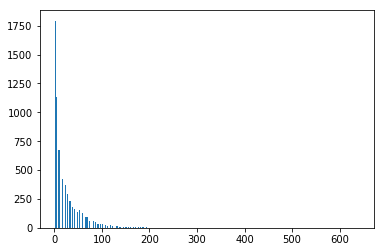

In [9]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [7]:
%load_ext Cython

In [8]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np
import time

DTYPE = np.float
GAP_PENALTY = 10.0

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 10), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                GAP_PENALTY + dp[i - 1][j    ],
                GAP_PENALTY + dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
start = time.time()
cdef np.ndarray distances = np.ones((n, n)) * float('inf')
cdef int i,j
for i in range(0, n):
    if i % 10 == 0:
        end = time.time()
        print("\t{} / {} in {} [sec]".format(i, n, end - start))
        start = time.time()
    for j in range(i, n):
        x = latent[i]
        y = latent[j]
        if np.abs(len(x[0]) - len(y[0])) < 5 and i < j:
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

	1020 / 6316 in 7.425677299499512 [sec]
	1030 / 6316 in 4.225318193435669 [sec]
	1040 / 6316 in 4.352138519287109 [sec]
	1050 / 6316 in 5.249490737915039 [sec]
	1060 / 6316 in 5.775031089782715 [sec]
	1070 / 6316 in 7.454577207565308 [sec]
	1080 / 6316 in 4.232883453369141 [sec]
	1090 / 6316 in 3.524181365966797 [sec]
	1100 / 6316 in 7.571500539779663 [sec]
	1110 / 6316 in 4.446935176849365 [sec]
	1120 / 6316 in 5.212910175323486 [sec]
	1130 / 6316 in 6.875787019729614 [sec]
	1140 / 6316 in 4.083204507827759 [sec]
	1150 / 6316 in 6.057681322097778 [sec]
	1160 / 6316 in 4.929076910018921 [sec]
	1170 / 6316 in 3.639052152633667 [sec]
	1180 / 6316 in 9.60071086883545 [sec]
	1190 / 6316 in 5.02708625793457 [sec]
	1200 / 6316 in 4.587980031967163 [sec]
	1210 / 6316 in 5.137771368026733 [sec]
	1220 / 6316 in 5.140463829040527 [sec]
	1230 / 6316 in 4.007136344909668 [sec]
	1240 / 6316 in 2.3255982398986816 [sec]
	1250 / 6316 in 5.397912263870239 [sec]
	1260 / 6316 in 3.6976068019866943 [sec]


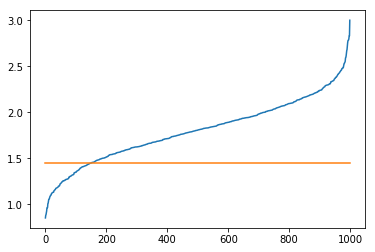

1.4536819010972977
3.632861375808716


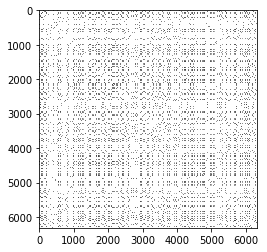

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 50)

plt.plot(sorted(f[0:1000]))
plt.plot(np.ones(1000) * th)
plt.show()
print(th)
max_val = np.max([d for d in distances.flatten() if not np.isinf(d)])
print(max_val)
for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isnan(distances[i][j]) or np.isinf(distances[i][j]):
            distances[i][j] = max_val
plt.imshow(distances, cmap='gray')
plt.show()

In [35]:
th = 1.0
n = len([x for x in distances.flatten() if x < th])
print("Distances < {}: {} / {} = {}".format(th, n, len(distances.flatten()), n / len(distances.flatten())))

Distances < 1.0: 63510 / 39891856 = 0.0015920542779458543


In [36]:
pickle.dump(distances, open( "distances_normal.p", "wb" ))

In [37]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )


In [38]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [39]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='average', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [40]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [41]:
final_clustering = [c for c in c if len(c) > 1 and len(c) < 800]
pickle.dump(final_clustering, open( "final_clustering.p", "wb" ) )
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

641
[2, 2, 2, 2, 5, 6, 2, 2, 2, 2, 8, 25, 6, 3, 2, 2, 2, 3, 46, 4, 10, 6, 4, 2, 3, 3, 2, 3, 3, 2, 2, 10, 2, 23, 30, 30, 2, 2, 3, 4, 2, 3, 3, 2, 5, 3, 2, 2, 3, 2, 2, 2, 10, 2, 11, 2, 16, 2, 4, 3, 7, 2, 8, 3, 2, 2, 2, 3, 4, 13, 7, 3, 2, 5, 7, 2, 2, 3, 3, 4, 3, 5, 2, 2, 2, 2, 3, 2, 2, 14, 2, 3, 2, 2, 2, 2, 3, 4, 3, 2, 3, 2, 3, 2, 2, 2, 9, 4, 3, 3, 2, 2, 2, 4, 3, 65, 15, 3, 2, 2, 2, 3, 2, 2, 3, 2, 7, 2, 3, 3, 3, 6, 6, 6, 4, 7, 2, 6, 2, 8, 2, 2, 2, 2, 2, 18, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 3, 3, 4, 3, 2, 6, 6, 4, 6, 11, 2, 3, 2, 64, 2, 3, 2, 3, 2, 61, 2, 4, 2, 2, 2, 2, 3, 5, 2, 7, 4, 7, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 5, 4, 3, 4, 3, 3, 17, 3, 9, 2, 2, 18, 2, 2, 3, 11, 2, 2, 2, 2, 5, 2, 4, 5, 3, 2, 2, 6, 7, 2, 2, 4, 2, 2, 2, 2, 3, 2, 7, 5, 2, 2, 2, 2, 2, 3, 5, 2, 2, 4, 3, 9, 2, 2, 5, 4, 2, 3, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 9, 6, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [33]:
from scipy.io import wavfile
import sys
from google.cloud import storage
import pickle
import random 

final_clustering = pickle.load(open( "final_clustering.p", "rb" ))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))

cache = {}
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

cx = 0
skip = 64
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {} {}".format(n, cx))
        audio = []
        sampled_cluster = cluster.copy()
        random.shuffle(sampled_cluster)
        sampled_cluster = sampled_cluster[:10]
        for i, region in enumerate(sampled_cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            if path in cache:
                stream = cache[path]
            else:                
                with open("/tmp/audio.m4a", "wb") as file_obj:
                    blob = bucket.blob(path)
                    blob.download_to_file(file_obj)
                stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
                cache[path] = stream              
                print(sys.getsizeof(cache))
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
        audio = np.array(audio, dtype=audio[0].dtype)
        wavfile.write('../data/results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1

[2, 17, 3, 5, 5, 11, 143, 2, 2, 17, 4, 7, 6, 23, 87, 13, 2, 7, 2, 2, 2, 6, 2, 2, 2, 2, 2, 10, 2, 2, 3, 6, 8, 2, 2, 87, 2, 2, 2, 162, 4, 4, 2, 4, 4, 24, 7, 6, 36, 8, 2, 11, 2, 3, 2, 4, 2, 8, 3, 4, 6, 11, 2, 2, 17, 29, 3, 3, 16, 2, 3, 4, 2, 3, 2, 25, 4, 2, 3, 5, 39, 55, 2, 12, 6, 4, 3, 2, 2, 32, 2, 5, 9, 2, 2, 3, 13, 2, 2, 2, 3, 9, 3, 3, 2, 10, 5, 17, 27, 2, 4, 4, 2, 31, 21, 5, 23, 44, 3, 4, 4, 6, 2, 32, 3, 3, 4, 2, 5, 3, 3, 3, 40, 41, 3, 16, 4, 16, 3, 4, 3, 5, 3, 4, 2, 17, 12, 2, 17, 6, 2, 2, 8, 9, 3, 2, 2, 3, 45, 3, 3, 3, 3, 2, 2, 2, 2, 8, 3, 2, 2, 3, 3, 20, 3, 2, 2, 4, 5, 6, 3, 3, 6, 3, 2, 2, 2, 3, 4, 23, 7, 9, 3, 3, 6, 3, 5, 2, 3, 4, 4, 8, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 6, 6, 11, 2, 3, 2, 2, 17, 3, 3, 3, 2, 9, 3, 2, 2, 11, 2, 5, 4, 4, 9, 26, 4, 5, 2, 5, 2, 5, 7, 3, 2, 10, 10, 8, 19, 9, 2, 2, 13, 3, 2, 8, 3, 11, 4, 2, 5, 2, 4, 2, 5, 15, 2, 2, 3, 2, 2, 8, 2, 26, 2, 2, 2, 4, 2, 4, 3, 15, 5, 11, 2, 4, 2, 2, 34, 5, 10, 2, 3, 3, 5, 6, 23, 2, 2, 3, 2, 2, 2, 5, 2, 4, 2, 2

OSError: [Errno 12] Cannot allocate memory

In [42]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

5054


In [43]:
import pickle
final_clustering = pickle.load(open( "final_clustering.p", "rb" ))

with db.connect() as conn:
    id = max_id + 1
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_lstm_v4_3', r['cluster'])        
            conn.execute(query)  
            id += 1